# Carry & Sum gates 

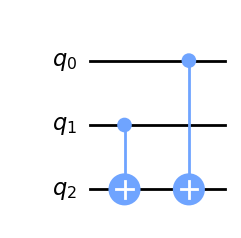

In [1]:
from qiskit import *
import numpy as np
from numpy import pi

#SUM Gate 
SG = QuantumCircuit(3,name="SUM")

SG.cnot(1,2)
SG.cnot(0,2)

SG.draw('mpl')

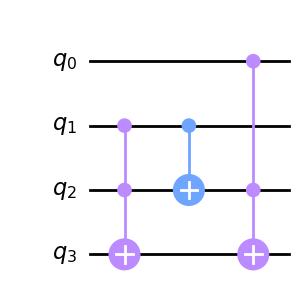

In [2]:
#CARRY Gate
CG = QuantumCircuit(4,name='CARRY')

CG.ccx(1,2,3)
CG.cnot(1,2)
CG.ccx(0,2,3)

CG.draw('mpl')

# Quantum Full Adder

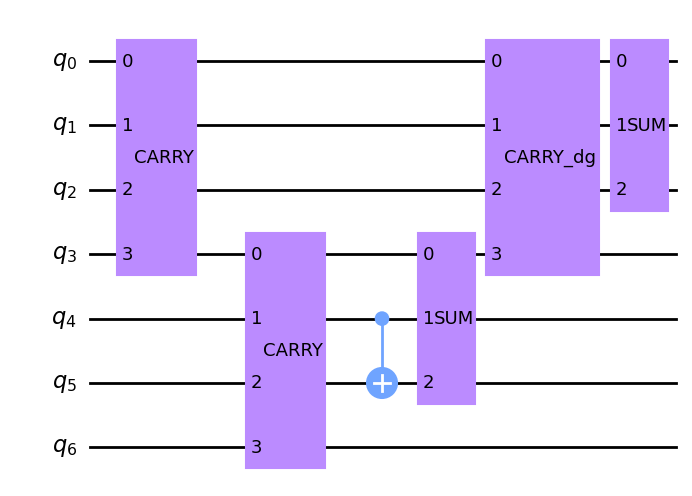

In [3]:
#2 bit QFA
qfa2 = QuantumCircuit(7,name=' QFA_2')

qfa2.append(CG,range(4))
qfa2.append(CG,range(3,7))
qfa2.cnot(4,5)
qfa2.append(SG,range(3,6))
qfa2.append(CG.inverse(),range(4))
qfa2.append(SG,range(3))

qfa2.draw('mpl')

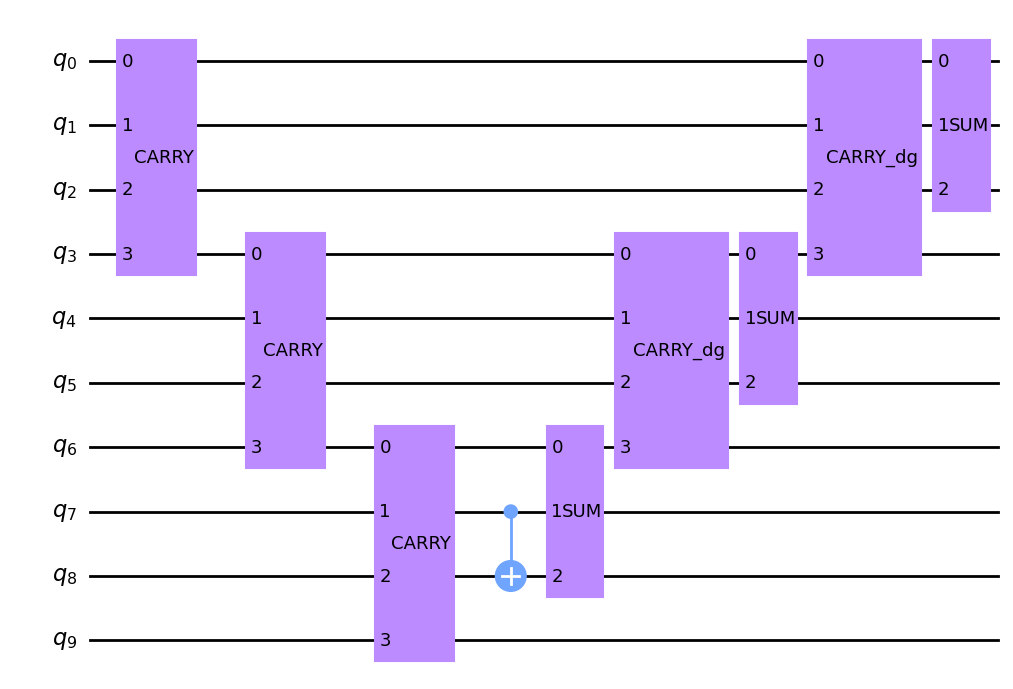

In [4]:
#3 bit QFA
qfa3 = QuantumCircuit(10,name =' QFA_3')

qfa3.append(CG,range(4))
qfa3.append(CG,range(3,7))
qfa3.append(CG,range(6,10))
qfa3.cnot(7,8)
qfa3.append(SG,range(6,9))
qfa3.append(CG.inverse(),range(3,7))
qfa3.append(SG,range(3,6))
qfa3.append(CG.inverse(),range(4))
qfa3.append(SG,range(3))

qfa3.draw('mpl')

# QFA Examples

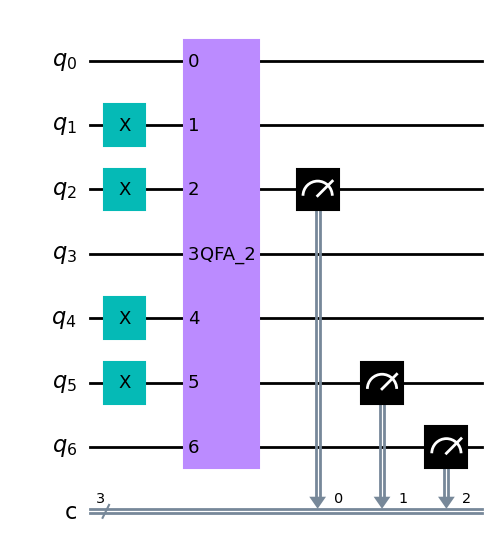

In [5]:
#2 bit adder

eg2b = QuantumCircuit(7,3)

#test with 11+11
eg2b.x(1)
eg2b.x(2)

eg2b.x(4)
eg2b.x(5)

eg2b.append(qfa2,range(7))

eg2b.measure(2,0)
eg2b.measure(5,1)
eg2b.measure(6,2)

eg2b.draw('mpl')

In [6]:
# Run the quantum circuit on a simulator backend and print the results

backend = Aer.get_backend('qasm_simulator')

result = execute(eg2b, backend, shots=1024).result()
counts = result.get_counts()
print(counts)

{'110': 1024}


As we expect, adding $11_{2}+11_{2}$ returns $110_{2}$, this shows that the adder is working optimally and accounting for the carry bit

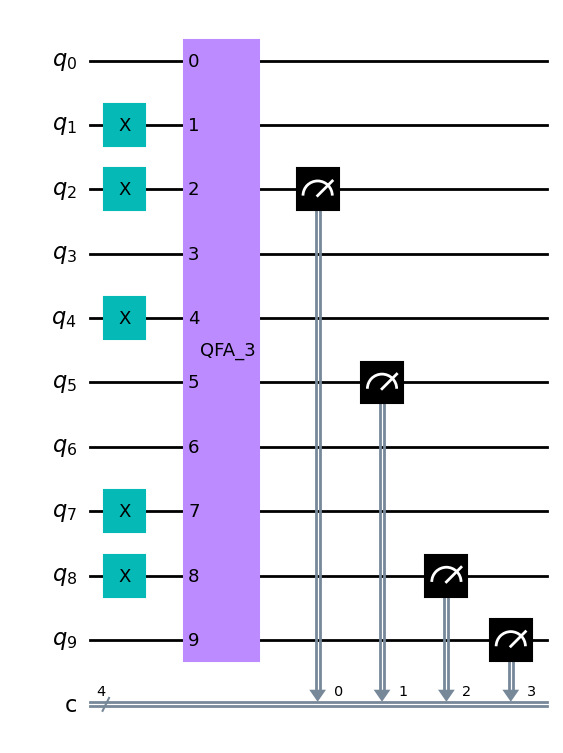

In [7]:
#3bit Adder
eg3b = QuantumCircuit(10,4)

#test with 111+101
eg3b.x(1)
eg3b.x(2)

eg3b.x(4)

eg3b.x(7)
eg3b.x(8)


eg3b.append(qfa3,range(10))

eg3b.measure(2,0)
eg3b.measure(5,1)
eg3b.measure(8,2)
eg3b.measure(9,3)

eg3b.draw('mpl')

In [8]:
# Run the quantum circuit on a simulator backend and print the results

backend = Aer.get_backend('qasm_simulator')

result = execute(eg3b, backend, shots=1024).result()
counts = result.get_counts()
print(counts)

{'1100': 1024}


As expected the addition of $111_{2}$ and $101_{2}$ produces the output of $1100_{2}$ showing the adder is working and is properly accounting for the carry bit.

# Quantum Fourier Transform

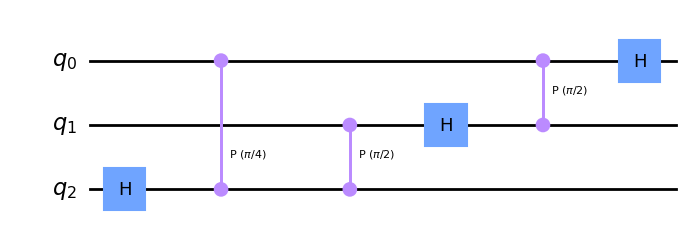

In [9]:
from qiskit import *
import numpy as np
from numpy import pi

#Adds the hadamard gates and rotation gates required to form the QFT
def qft(circuit, n):
    """Performs QFT on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # Recursively add the rotation and hadamard gates starting from the last qubit
    qft(circuit, n)


def iqft(circuit, n):
    """inverse QFT on the first n qubits in circuit"""
    qftc = QuantumCircuit(n)
    qft(qftc,n)
    iqftc = qftc.inverse()
    circuit.append(iqftc,range(n))
    return circuit.decompose()

#eg
qft_circ = QuantumCircuit(3,name=' QFT_ivy')
qft(qft_circ,3)
qft_circ.draw('mpl')


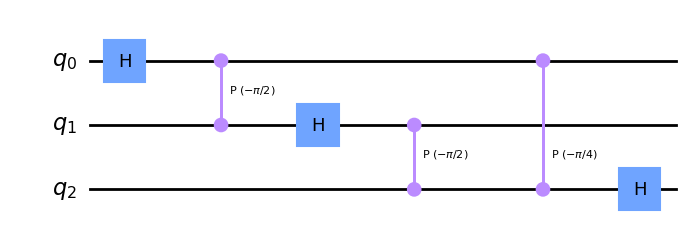

In [10]:
#inverse QFT 
iqft_circ = QuantumCircuit(3,name = ' IQFT_ivy')
iqft_circ = iqft(iqft_circ,3)
iqft_circ.draw('mpl')

# Example of the QFT & IQFT in action

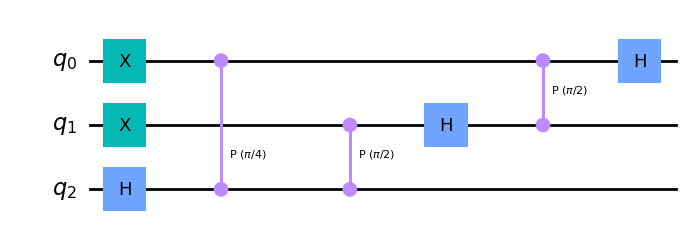

In [11]:
eg_circ = QuantumCircuit(3)
#showing the quantum fourier state of 011 or 3
eg_circ.x(0)
eg_circ.x(1)
#eg_circ.append(qft_circ,range(3))
qft(eg_circ,3)
eg_circ.draw('mpl')

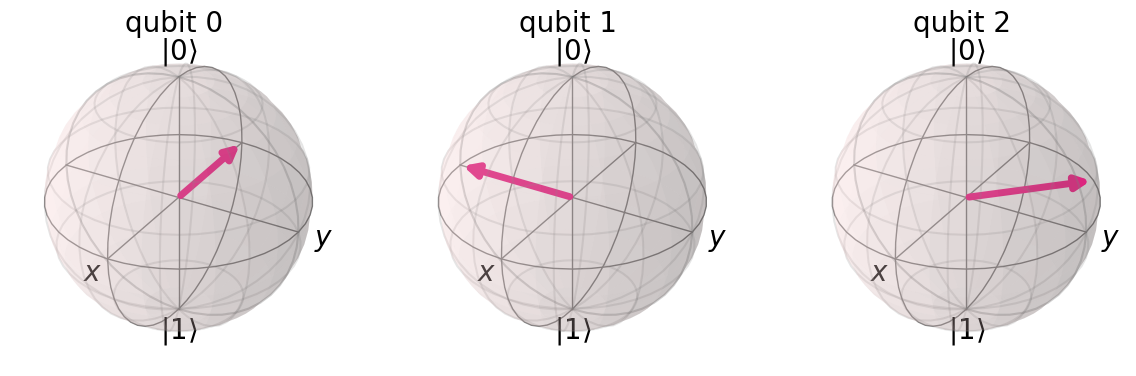

In [12]:
from qiskit.visualization import plot_histogram, plot_bloch_multivector
sim = Aer.get_backend("aer_simulator")
eg_circ2 = eg_circ.copy()
eg_circ.save_statevector()
statevector1 = sim.run(eg_circ).result().get_statevector()
plot_bloch_multivector(statevector1)

I elected not to swap the registers to keep the LSB to the right i.e. $q_{2}$.
It can be seen that the fourier transform is performing as it should with $q_{2}$ showing $\frac{3}{8}$ of a full rotation, $q_{1}$ with $\frac{6}{8}$ or $\frac{3}{4}$ of a full rotation and lastly $q_{0}$ with $\frac{12}{8}$ or equivalently $\frac{1}{2}$ rotation. This is as expected.

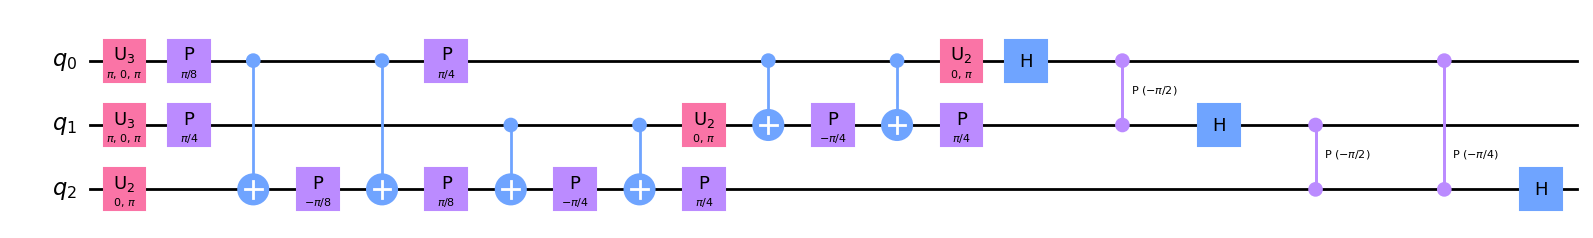

In [13]:
eg_circ2 = iqft(eg_circ2,3)
eg_circ2.draw('mpl')

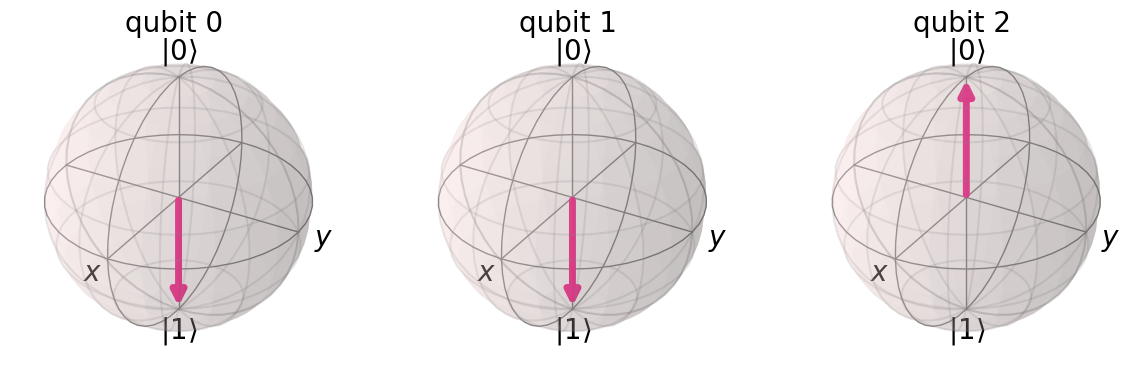

In [14]:
eg_circ2.save_statevector()
statevector2 = sim.run(eg_circ2).result().get_statevector()
plot_bloch_multivector(statevector2)

As expected we are returned our original bit pattern of 011, read from right to left.

# Approximate Fourier Transform

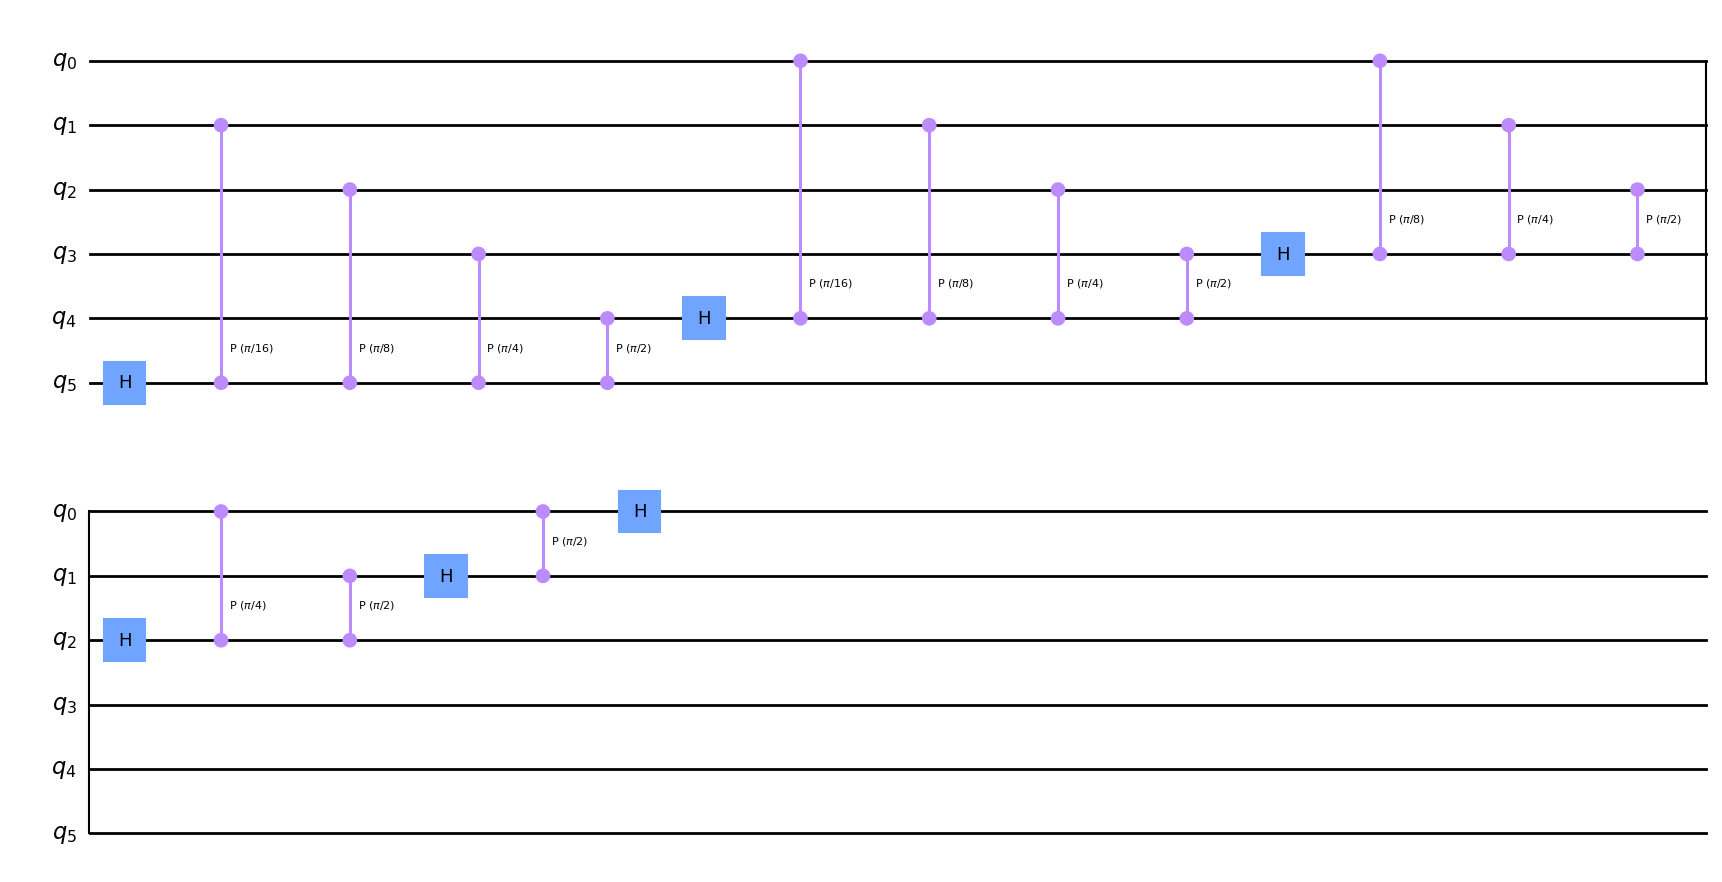

In [15]:
from qiskit import *
import numpy as np
from numpy import pi

#Adds the hadamard gates and rotation gates required to form the QFT
def aqft(circuit, n,m):
    """Performs AQFT on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    if n<m:
        m-=1
    #only adds as manny CROT gates as the degree of the AQFT given by m
    for qubit in range(m,0,-1):
        circuit.cp(pi/2**(qubit), n-qubit, n)
    # Recursively add the rotation and hadamard gates starting from the last qubit
    aqft(circuit,n,m)


def iaqft(circuit, n,m):
    """inverse AQFT on the first n qubits in circuit"""
    aqftc = QuantumCircuit(n)
    aqft(aqftc,n,m)
    iaqftc = aqftc.inverse()
    circuit.append(iaqftc,range(n))
    return circuit.decompose()

#eg
aqft_circ = QuantumCircuit(6,name=' AQFT_ivy')
aqft(aqft_circ,6,4)
aqft_circ.draw('mpl')

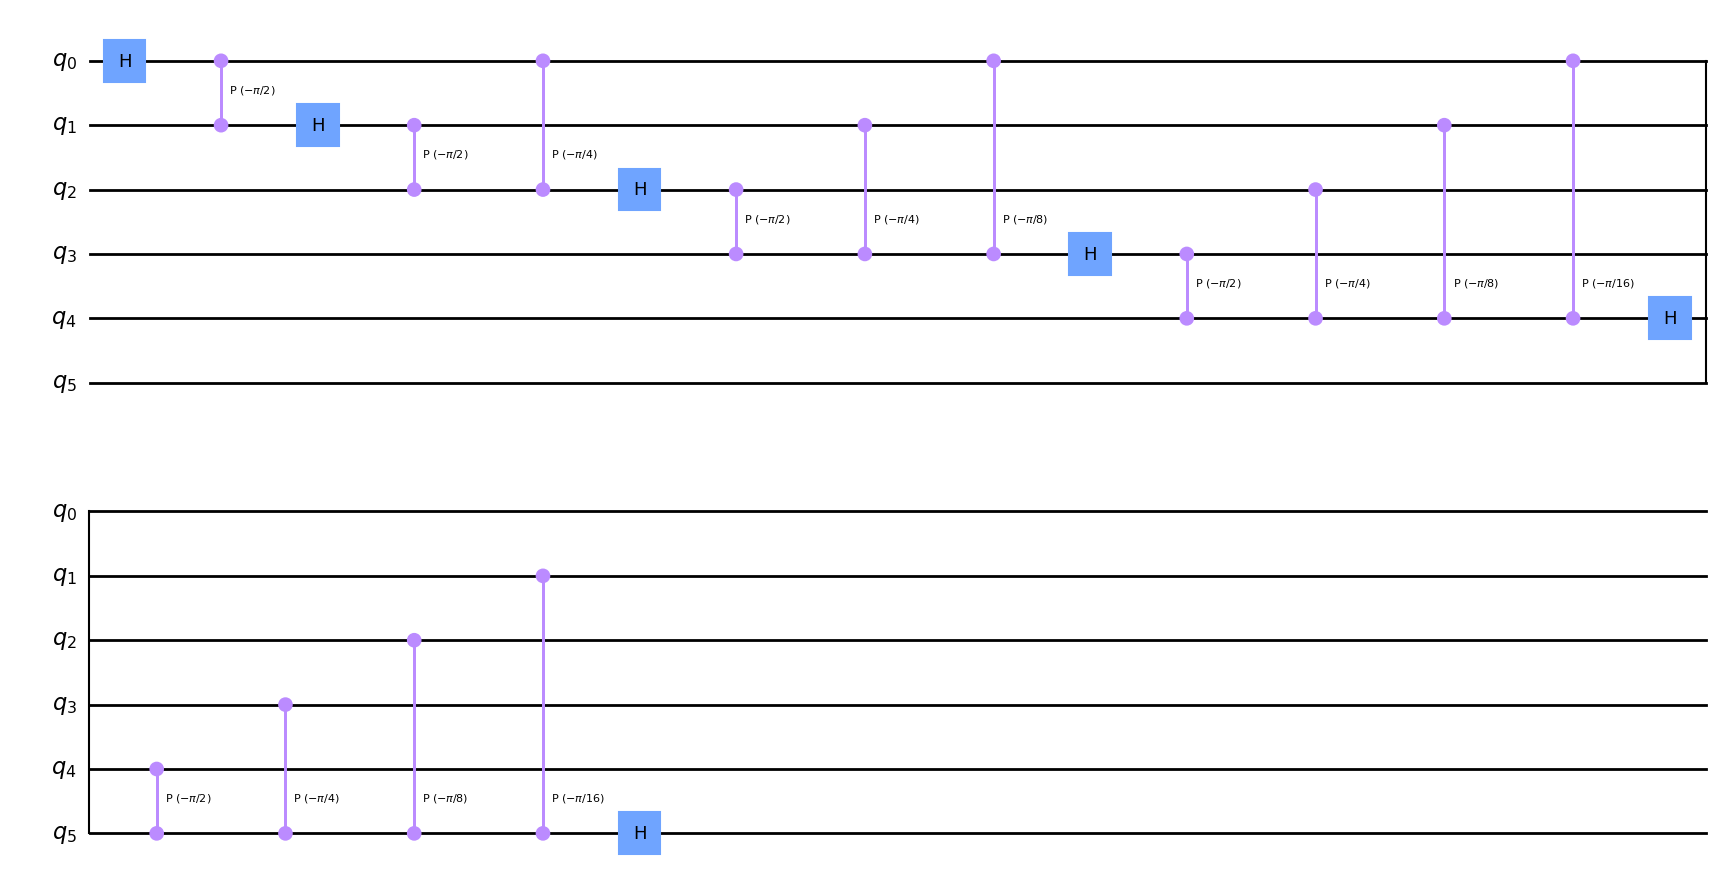

In [16]:
#inverse QFT 
iaqft_circ = QuantumCircuit(6,name = ' IAQFT_ivy')
iaqft_circ = iaqft(iaqft_circ,6,4)
iaqft_circ.draw('mpl')

# QFT Adders

In this section, the 2 bit and 3 bit adders will be built and tested. The circuit design was inspired from the DraperQFTAdder function that is built into Qiskit's libraries. 

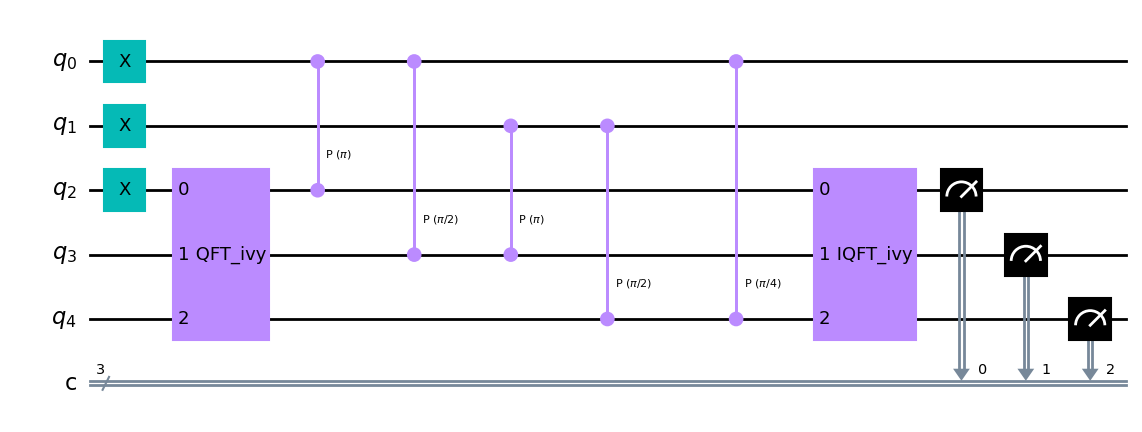

In [17]:
# Import the necessary modules from Qiskit
from qiskit import *
from qiskit import QuantumCircuit, execute, Aer
from math import pi

#2 bit adder

# Define the inputs to the adder (in this example, we'll add 3 and 5)
a = 3
b = 1

# Determine the number of qubits required to represent the inputs
n = max(len(bin(a)), len(bin(b))) - 2

# Create a quantum circuit with n qubits and n+1 classical bits
qc = QuantumCircuit(5,3)

for i in range(2):
    if (a & (1 << i)):
        qc.x(i)
    if (b & (1 << i)):
        qc.x(2+i)

#qc.x(0)
#qc.x(1)
#qc.x(2)
#qc.x(3)
# Apply the quantum Fourier transform to the first n qubits
qc.append(qft_circ, range(2,5))

# Add the qubits (using a ripple-carry adder)
qc.cp(pi,0,2)
qc.cp(pi/2,0,3)
qc.cp(pi,1,3)
qc.cp(pi/2,1,4)
qc.cp(pi/4,0,4)

# Apply the inverse Fourier transform to the first n qubits
qc.append(iqft_circ, range(2,5))
qc.measure(range(2,5),range(3))
qc.draw('mpl')

In [18]:


# Run the quantum circuit on a simulator backend and print the results

backend = Aer.get_backend('qasm_simulator')

result = execute(qc, backend, shots=1024).result()
counts = result.get_counts()
print(counts)

{'100': 1024}


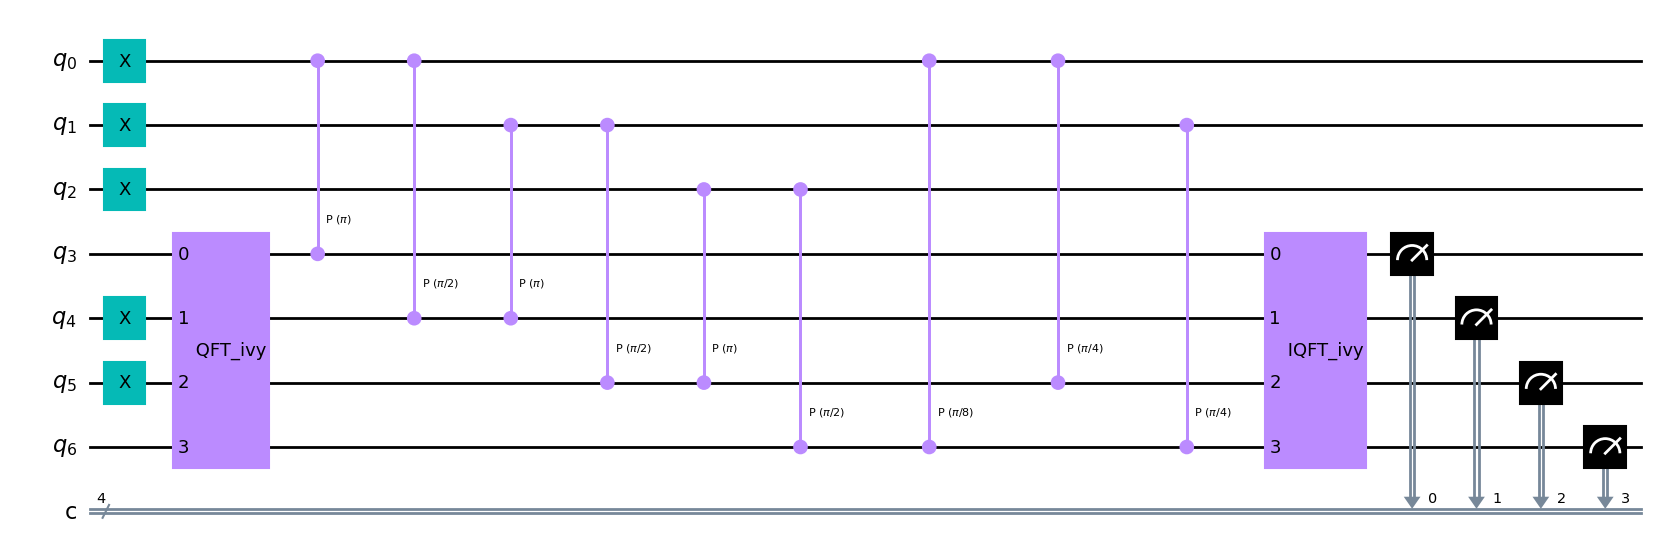

In [19]:
#3-bit Adder
# Import the necessary modules from Qiskit
from qiskit import *
from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit.library import QFT
from math import pi

# Define the inputs to the adder (in this example, we'll add 7 and 6)
a = 7
b = 6

# Determine the number of qubits required to represent the inputs
n = max(len(bin(a)), len(bin(b))) - 2

# Create a quantum circuit with n qubits and n+1 classical bits
qc = QuantumCircuit(7,4)

for i in range(2,-1,-1):
    if (a & (1 << i)):
        qc.x(i)
    if (b & (1 << i)):
        qc.x(3+i)

qft_circ = QuantumCircuit(4,name=' QFT_ivy')
qft(qft_circ,4)

# Apply the quantum Fourier transform to the first n qubits
qc.append(qft_circ, range(3,7))

# Add the qubits (using a ripple-carry adder)
qc.cp(pi,0,3)
qc.cp(pi/2,0,4)
qc.cp(pi,1,4)
qc.cp(pi/2,1,5)
qc.cp(pi,2,5)
qc.cp(pi/2,2,6)
qc.cp(pi/8,0,6)
qc.cp(pi/4,0,5)
qc.cp(pi/4,1,6)

#inverse QFT 
iqft_circ = QuantumCircuit(4,name = ' IQFT_ivy')
iqft_circ = iqft(iqft_circ,4)

# Apply the inverse Fourier transform to the first n qubits
qc.append(iqft_circ, range(3,7))
qc.measure(range(3,7),range(4))
qc.draw('mpl')

In [20]:
# Run the quantum circuit on a simulator backend and print the results

backend = Aer.get_backend('qasm_simulator')

result = execute(qc, backend, shots=1024).result()
counts = result.get_counts()
print(counts)

{'1101': 1024}
